In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
start_time = time.time()

# Import Model

In [2]:
models_path = os.path.join(os.getcwd(),'trained_models')
models = os.listdir(models_path)
for i, path in enumerate(models):
    print(f"{i}   {path}")

0   2024_10_07 17-55-55 Deep Neural Network 3oosRMSE
1   2024_10_08 00-00-41 Deep Neural Network 3oosRMSE
2   2024_10_08 00-24-59 Deep Neural Network 3oosRMSE
3   2024_10_08 00-42-22 Deep Neural Network 3oosRMSE
4   2024_10_09 09-01-43 Deep Neural Network 6oosRMSE
5   2024_10_09 09-08-27 Deep Neural Network 9oosRMSE
6   2024_10_09 09-11-43 Deep Neural Network 11oosRMSE
7   2024_10_09 10-09-20 Deep Neural Network 15oosRMSE
8   2024_10_09 11-11-13 Deep Neural Network 16oosRMSE


In [3]:
model = models[8]
model

'2024_10_09 11-11-13 Deep Neural Network 16oosRMSE'

In [4]:
model_path = os.path.join(models_path,model)

In [5]:
model_files = os.listdir(model_path)
model_files

['2024_10_09 11-11-13 Deep Neural Network 16oosRMSE insample.csv',
 '2024_10_09 11-11-13 Deep Neural Network 16oosRMSE outsample.csv',
 '2024_10_09 11-11-13 Deep Neural Network 16oosRMSE.pkl',
 '2024_10_09 11-11-13 Deep Neural Network 16oosRMSE.txt']

In [6]:
spec_path = os.path.join(model_path,[file for file in model_files if file.endswith('.txt')][0])

In [7]:
with open(spec_path, "r") as specs:
    for line in specs:
        print(line.strip())

Wed Oct  9 11:09:07 2024
spot(s):
[1214.91 1228.34 1235.03 1240.01 1244.81 1245.64 1251.98 1253.33 1253.75
1257.85 1259.82 1260.44 1260.47 1261.75 1263.07 1263.23 1267.3  1273.68
1274.24 1276.78 1276.84 1279.06 1279.51 1281.9  1283.57 1284.14 1285.13
1288.77 1293.41 1298.46 1304.46 1308.8  1311.13 1314.51 1314.81 1315.19
1317.94 1318.45 1320.45 1322.21 1322.24 1325.42 1325.9  1326.38 1326.79
1328.62 1329.65 1329.75 1330.53 1330.91 1331.14 1331.49 1333.24 1333.44
1333.8  1334.79 1335.63 1336.97 1337.24 1338.18 1338.73 1339.01 1340.15
1340.92 1342.48 1342.83 1348.8  1348.82 1348.83 1349.69 1349.91 1350.78
1351.52 1352.69 1353.69 1353.73 1354.63 1354.95 1358.24 1359.88 1360.
1360.03 1360.47 1360.48 1362.14 1363.84 1365.56 1365.65 1366.54 1367.41
1367.69 1369.22 1369.79 1370.68 1371.44 1372.41 1372.91 1374.2  1376.17
1376.18 1376.5  1377.07 1377.59 1377.99 1379.83 1380.11 1380.72 1380.79
1381.38 1385.23 1385.42 1385.74 1386.77 1386.98 1387.16 1388.04 1388.3
1388.63 1390.08 1390.45 1390.84 

In [9]:
model_files

['2024_10_09 11-11-13 Deep Neural Network 16oosRMSE insample.csv',
 '2024_10_09 11-11-13 Deep Neural Network 16oosRMSE outsample.csv',
 '2024_10_09 11-11-13 Deep Neural Network 16oosRMSE.pkl',
 '2024_10_09 11-11-13 Deep Neural Network 16oosRMSE.txt']

In [10]:
# insample_path = os.path.join(model_path,[file for file in model_files if file.find('insample') != -1][0])
# insample = pd.read_csv(insample_path).iloc[:,1:]
# insample

In [11]:
outsample_path = os.path.join(model_path,[file for file in model_files if file.find('outsample') != -1][0])
outsample = pd.read_csv(outsample_path).iloc[:,1:]
outsample

,spot_price,strike_price,barrier,days_to_maturity,barrier_price,updown,outin,w,barrier_type_name,rebate,...,kappa,rho,eta,v0,calculation_date,expiration_date,observed_price,outofsample_target,outofsample_prediction,outofsample_error
0,1260.39,1134.35,630.20,180,0.29,Down,In,put,DownIn,0.00,...,1.69,-1.00,0.15,0.04,2008-08-01,2009-01-28,0.66,0.66,0.24,-0.42
1,1260.39,1134.35,630.20,360,5.81,Down,In,put,DownIn,0.00,...,1.69,-1.00,0.15,0.04,2008-08-01,2009-07-27,5.98,5.98,8.43,2.45
2,1260.39,1134.35,630.20,540,16.96,Down,In,put,DownIn,0.00,...,1.69,-1.00,0.15,0.04,2008-08-01,2010-01-23,16.91,16.91,14.30,-2.60
3,1260.39,1134.35,630.20,720,29.92,Down,In,put,DownIn,0.00,...,1.69,-1.00,0.15,0.04,2008-08-01,2010-07-22,30.00,30.00,32.32,2.33
4,1260.39,1134.35,784.59,90,0.14,Down,In,put,DownIn,0.00,...,1.69,-1.00,0.15,0.04,2008-08-01,2008-10-30,0.33,0.33,-0.29,-0.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315674,969.87,1066.86,1454.81,90,21.11,Up,In,call,UpIn,0.00,...,3.47,-1.00,0.31,0.30,2008-10-31,2009-01-29,21.15,21.15,91.85,70.70
315675,969.87,1066.86,1454.81,180,54.06,Up,In,call,UpIn,0.00,...,3.47,-1.00,0.31,0.30,2008-10-31,2009-04-29,53.80,53.80,123.18,69.37
315676,969.87,1066.86,1454.81,360,98.65,Up,In,call,UpIn,0.00,...,3.47,-1.00,0.31,0.30,2008-10-31,2009-10-26,98.79,98.79,174.31,75.52
315677,969.87,1066.86,1454.81,540,130.38,Up,In,call,UpIn,0.00,...,3.47,-1.00,0.31,0.30,2008-10-31,2010-04-24,130.28,130.28,213.92,83.64


# Train Model

In [12]:
# from train_main import model_fit, outsample, insample

# Test Model

In [13]:
maturities = outsample['days_to_maturity'].unique().tolist()
barrier_type_names = outsample['barrier_type_name'].unique().tolist()
ws = outsample['w'].unique().tolist()
print(f"\nmaturities:\n     maturities = {maturities}")
print(f"\ntypes:\n     barrier_type_names = {barrier_type_names}\n     ws = {ws}\n")


maturities:
     maturities = [180, 360, 540, 720, 90, 60]

types:
     barrier_type_names = ['DownIn', 'UpIn']
     ws = ['put', 'call']



In [14]:
by_wbt = outsample.copy().set_index(['w','barrier_type_name','days_to_maturity']).sort_index()

In [15]:
RMSE = pd.DataFrame(
    np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
    columns = barrier_type_names,
    index = maturities
)

for t in maturities:
    for b in barrier_type_names:
        RMSE.loc[t,b] = np.sqrt(np.average((by_wbt.loc[(slice(None), b, t),'outofsample_error'])**2))
print(f"\nRMSE:\n{RMSE}")


RMSE:
     DownIn  UpIn
180   15.50 13.41
360   16.40 15.04
540   16.75 16.33
720   17.87 18.29
90    16.75 13.83
60    18.02 15.27


In [16]:
MAE = pd.DataFrame(
    np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
    index = maturities,
    columns = barrier_type_names
)
for t in maturities:
    for b in barrier_type_names:
        MAE.loc[t,b] = np.average(np.abs(by_wbt.loc[(slice(None), b, t),'outofsample_error']))
print(f"\nMAE:\n{MAE}")


MAE:
     DownIn  UpIn
180    6.13  6.07
360    7.44  7.25
540    7.78  7.62
720    8.51  8.92
90     6.24  5.64
60     6.78  6.13


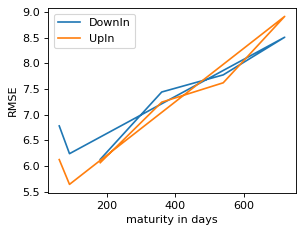

In [17]:
plt.figure(figsize=(4, 3),dpi=80)
for b in barrier_type_names:
    plt.plot(MAE.loc[:, b], label=b)
plt.xlabel('maturity in days')
plt.ylabel('RMSE')
plt.legend()
plt.show()
plt.close()

In [18]:
errors_bypayoff = {}
for w in ws:
    errors = {}
    RMSE = pd.DataFrame(
        np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
        columns = barrier_type_names
        )
    RMSE[w] = maturities
    RMSE = RMSE.set_index(w,drop=True)
    for t in maturities:
        for b in barrier_type_names:
            RMSE.loc[t,b] = np.sqrt(np.average((by_wbt.loc[(w, b, t),'outofsample_error'])**2))
    errors['RMSE'] = RMSE

    MAE = pd.DataFrame(
        np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
        columns = barrier_type_names
    )
    MAE[w] = maturities
    MAE = MAE.set_index(w,drop=True)
    for t in maturities:
        for b in barrier_type_names:
            MAE.loc[t,b] = np.average(np.abs(by_wbt.loc[(w, b, t),'outofsample_error']))
    errors['MAE'] = MAE

    errors_bypayoff[w] = errors

In [19]:
for w, errors in errors_bypayoff.items():
    print("RMSE:\n")
    print(errors['RMSE'])
    print()

RMSE:

     DownIn  UpIn
put              
180   19.86  8.98
360   20.25  9.34
540   19.54  9.76
720   19.58 11.28
90    21.41  9.06
60    22.82 10.04

RMSE:

      DownIn  UpIn
call              
180     9.03 16.73
360    11.31 19.11
540    13.40 20.93
720    15.97 23.28
90      9.06 17.44
60      9.82 19.12



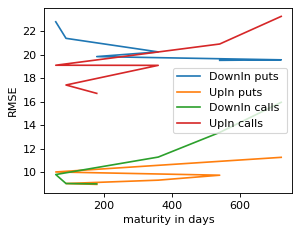

In [20]:
plt.figure(figsize=(4, 3),dpi=80)
for w, errors in errors_bypayoff.items():
    for b in barrier_type_names: 
        MAE = errors['RMSE'][b]
        plt.plot(
            MAE.sort_values(), label=f"{b} {w}s ",
        )
plt.legend(loc='best')
plt.ylabel('RMSE')
plt.xlabel('maturity in days')
plt.show()
plt.close()

In [21]:
for w, errors in errors_bypayoff.items():
    print("MAE:\n")
    print(errors['MAE'])
    print()

MAE:

     DownIn  UpIn
put              
180    9.06  3.08
360   10.62  3.62
540   10.36  4.08
720   10.69  4.95
90     9.12  2.97
60     9.74  3.51

MAE:

      DownIn  UpIn
call              
180     3.11  9.09
360     4.27 10.87
540     5.19 11.17
720     6.33 12.89
90      3.03  8.41
60      3.34  8.75



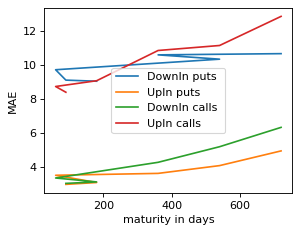

In [22]:
plt.figure(figsize=(4, 3),dpi=80)
for w, errors in errors_bypayoff.items():
    for b in barrier_type_names: 
        MAE = errors['MAE'][b]
        plt.plot(
            MAE.sort_values(), label=f"{b} {w}s ",
        )
plt.legend(loc='best')
plt.ylabel('MAE')
plt.xlabel('maturity in days')
plt.show()
plt.close()

In [23]:
end_time = time.time()
runtime = end_time - start_time
print(f"cpu: {runtime}")
pd.reset_option("display.max_columns")
pd.reset_option("display.max_rows")

cpu: 0.8188481330871582
